[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\User\anaconda3\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

C:\Users\User\anaconda3\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss
1,No log,0.510928
2,No log,0.466675
3,No log,0.448557


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, clean_text. If __index_level_0__, clean_text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, clean_text. If __index_level_0__, clean_text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, clean_text. If __index_level_0__, clean_text are not expected by `BertForSequenceClas

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Accuracy Score: 100.00%


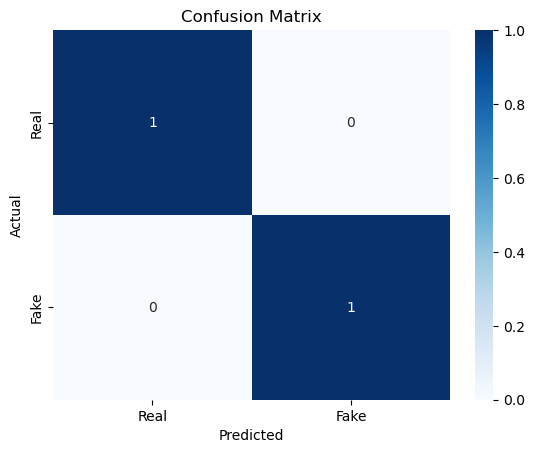

Prediction: Real News


In [1]:
# If running in a Jupyter notebook or script, you can install missing modules like this:
try:
    from datasets import Dataset
except ImportError:
    import os
    os.system("pip install datasets")
    from datasets import Dataset

import pandas as pd
import numpy as np
import re
import torch
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

nltk.download('stopwords')

# Load dataset
df = pd.read_csv('campus_news.csv')

# Combine title and content
df['text'] = df['title'] + " " + df['content']

# Clean the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\W", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text

df['clean_text'] = df['text'].apply(clean_text)

# Encode labels
df['label'] = df['label'].map({'real': 0, 'fake': 1})

# Split the data
train_df, test_df = train_test_split(df[['clean_text', 'label']], test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize
def tokenize_function(example):
    return tokenizer(example["clean_text"], truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Load pre-trained model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Training configuration
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Train model
trainer.train()

# Predict and evaluate
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

print("Classification Report:\n", classification_report(y_true, y_pred))
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy Score: {accuracy * 100:.2f}%")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Predict new news
def predict_news(news_text):
    cleaned = clean_text(news_text)
    inputs = tokenizer(cleaned, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()
    return "Fake News" if pred == 1 else "Real News"

# Test prediction
new_news = "Vice Chancellor has announced a new policy for final year students."
print("Prediction:", predict_news(new_news))
